In [1]:
%load_ext autoreload
%autoreload 2

In [246]:
from collections import defaultdict
from copy import deepcopy
import json
import os
import warnings
import glob
import re
from io import StringIO, BytesIO
from functools import partial
from typing import Tuple

import h5py
import k3d
import yaml
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from joblib import Parallel, delayed
import xml.etree.ElementTree as ET
import trimesh
import trimesh.transformations as tt

In [196]:
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
import sharpf.data.datasets.sharpf_io as sharpf_io
import sharpf.utils.abc_utils.hdf5.io_struct as io
from sharpf.utils.plotting import display_depth_sharpness
from sharpf.utils.py_utils.config import load_func_from_config
from sharpf.data.imaging import IMAGING_BY_TYPE
from sharpf.utils.camera_utils.camera_pose import camera_to_display, CameraPose

In [92]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r):
    
    plot = k3d.plot(height=plot_height)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            max_dist = 0.5

            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width)
            print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))

In [9]:
# mm/pixel
HIGH_RES = 0.02
MED_RES = 0.05
LOW_RES = 0.125
XLOW_RES = 0.25

DISPLAY_RES = 0.03

In [10]:
UnlabeledSLDepthMapIO = io.HDF5IO({
        'image': io.Float64('image'),
        'image_offset': io.Float64('image_offset'),
        'item_id': io.AsciiString('item_id'),
        'camera_extrinsics': io.Float64('camera_extrinsics'),
        'camera_intrinsics_f': io.Float64('camera_intrinsics_f'),
        'camera_intrinsics_s': io.Float64('camera_intrinsics_s'),
    },
    len_label='has_sharp',
    compression='lzf')

In [429]:
base_groundtruth_dir = '/data/abc/sharp_features_whole_models'

base_predictions_dir = '/logs/whole_models_inference_final'

obj_name = '20201112_40cm_hook'

## Display whole model without predictions 

In [430]:
ground_truth_filename = os.path.join(base_groundtruth_dir, obj_name, obj_name + '.hdf5')
ground_truth_dataset = Hdf5File(
    ground_truth_filename,
    io=UnlabeledSLDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels='*')

ground_truth = [view for view in ground_truth_dataset]
gt_images = [view['image'] for view in ground_truth]
gt_distances = [view.get('distances', np.ones_like(view['image'])) for view in ground_truth]
gt_extrinsics = [view['camera_extrinsics'] for view in ground_truth]
gt_intrinsics_f = [view['camera_intrinsics_f'] for view in ground_truth]
gt_intrinsics_s = [view['camera_intrinsics_s'] for view in ground_truth]
gt_offsets = [view['image_offset'] for view in ground_truth]
gt_items = [view['item_id'].decode() for view in ground_truth]

File /data/abc/sharp_features_whole_models/20201112_40cm_hook/20201112_40cm_hook.hdf5 is not compatible with Hdf5File I/O interface <class 'sharpf.utils.abc_utils.hdf5.io_struct.HDF5IO'>
File /data/abc/sharp_features_whole_models/20201112_40cm_hook/20201112_40cm_hook.hdf5 is not compatible with Hdf5File I/O interface <class 'sharpf.utils.abc_utils.hdf5.io_struct.HDF5IO'>


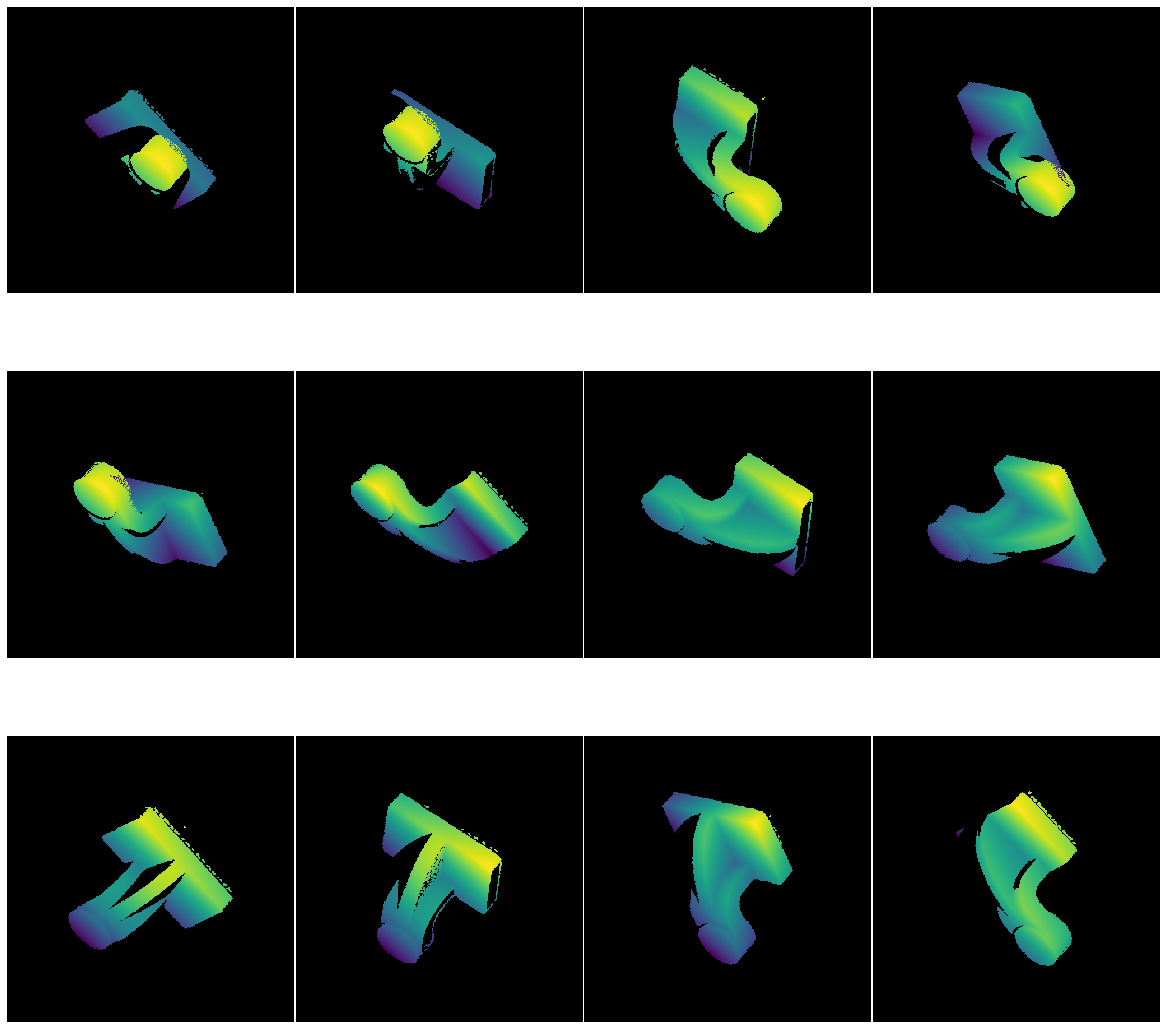

In [431]:
display_depth_sharpness(
    depth_images=gt_images,
    axes_size=(16, 16),
    ncols=4
)

In [432]:
with open('/code/scripts/data_scripts/configs/depthmap_datasets/high_res_whole.json') as config_file:
    config = json.load(config_file)
    config['imaging']['resolution_image'] = gt_images[0].shape[0]
imaging = load_func_from_config(IMAGING_BY_TYPE, config['imaging'])
# print(imaging.resolution_image, gt_images[0].shape)



In [433]:
def convert_npylist_to_hdf5(input_dir, output_filename):
    PointPatchPredictionsIO = io.HDF5IO(
        {'distances': io.Float64('distances')},
        len_label='distances',
        compression='lzf')

    def save_predictions(patches, filename):
        collate_fn = partial(io.collate_mapping_with_io, io=PointPatchPredictionsIO)
        patches = collate_fn(patches)
        with h5py.File(filename, 'w') as f:
            PointPatchPredictionsIO.write(f, 'distances', patches['distances'])

    def get_num(basename):
        match = re.match('^test_(\d+)\.npy$', basename)
        return int(match.groups()[0])

    datafiles = glob.glob(os.path.join(input_dir, '*.npy'))
    datafiles.sort(key=lambda name: get_num(os.path.basename(name)))
    patches = [{'distances': np.load(f)} for f in datafiles]
    save_predictions(patches, output_filename)

In [434]:
predictions_dir = os.path.join(
    base_predictions_dir,
    'predictions/images/sl_v2_high',
    '0.0/resnet152/regression',
    obj_name,
    'predictions'
)
predictions_filename = os.path.join(
    base_predictions_dir,
    'combined/images/sl_high',
    '0.0/resnet152/regression'
    '{}__{}.hdf5'.format(obj_name, 'predictions'))
os.makedirs(os.path.dirname(predictions_filename), exist_ok=True)

convert_npylist_to_hdf5(predictions_dir, predictions_filename)

In [435]:
PointPatchPredictionsIO = io.HDF5IO(
        {'distances': io.Float64('distances')},
        len_label='distances',
        compression='lzf')

predictions_dataset = Hdf5File(
    predictions_filename,
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

pred_images_distances = [patch['distances'] for patch in predictions_dataset]

pred_images_distances_masked = []
for image, distances in zip(gt_images, pred_images_distances):
    distances_masked = np.zeros_like(distances)
    distances_masked[image == 0.] = 0.
    distances_masked[image != 0.] = distances[image != 0.]
    pred_images_distances_masked.append(distances_masked)

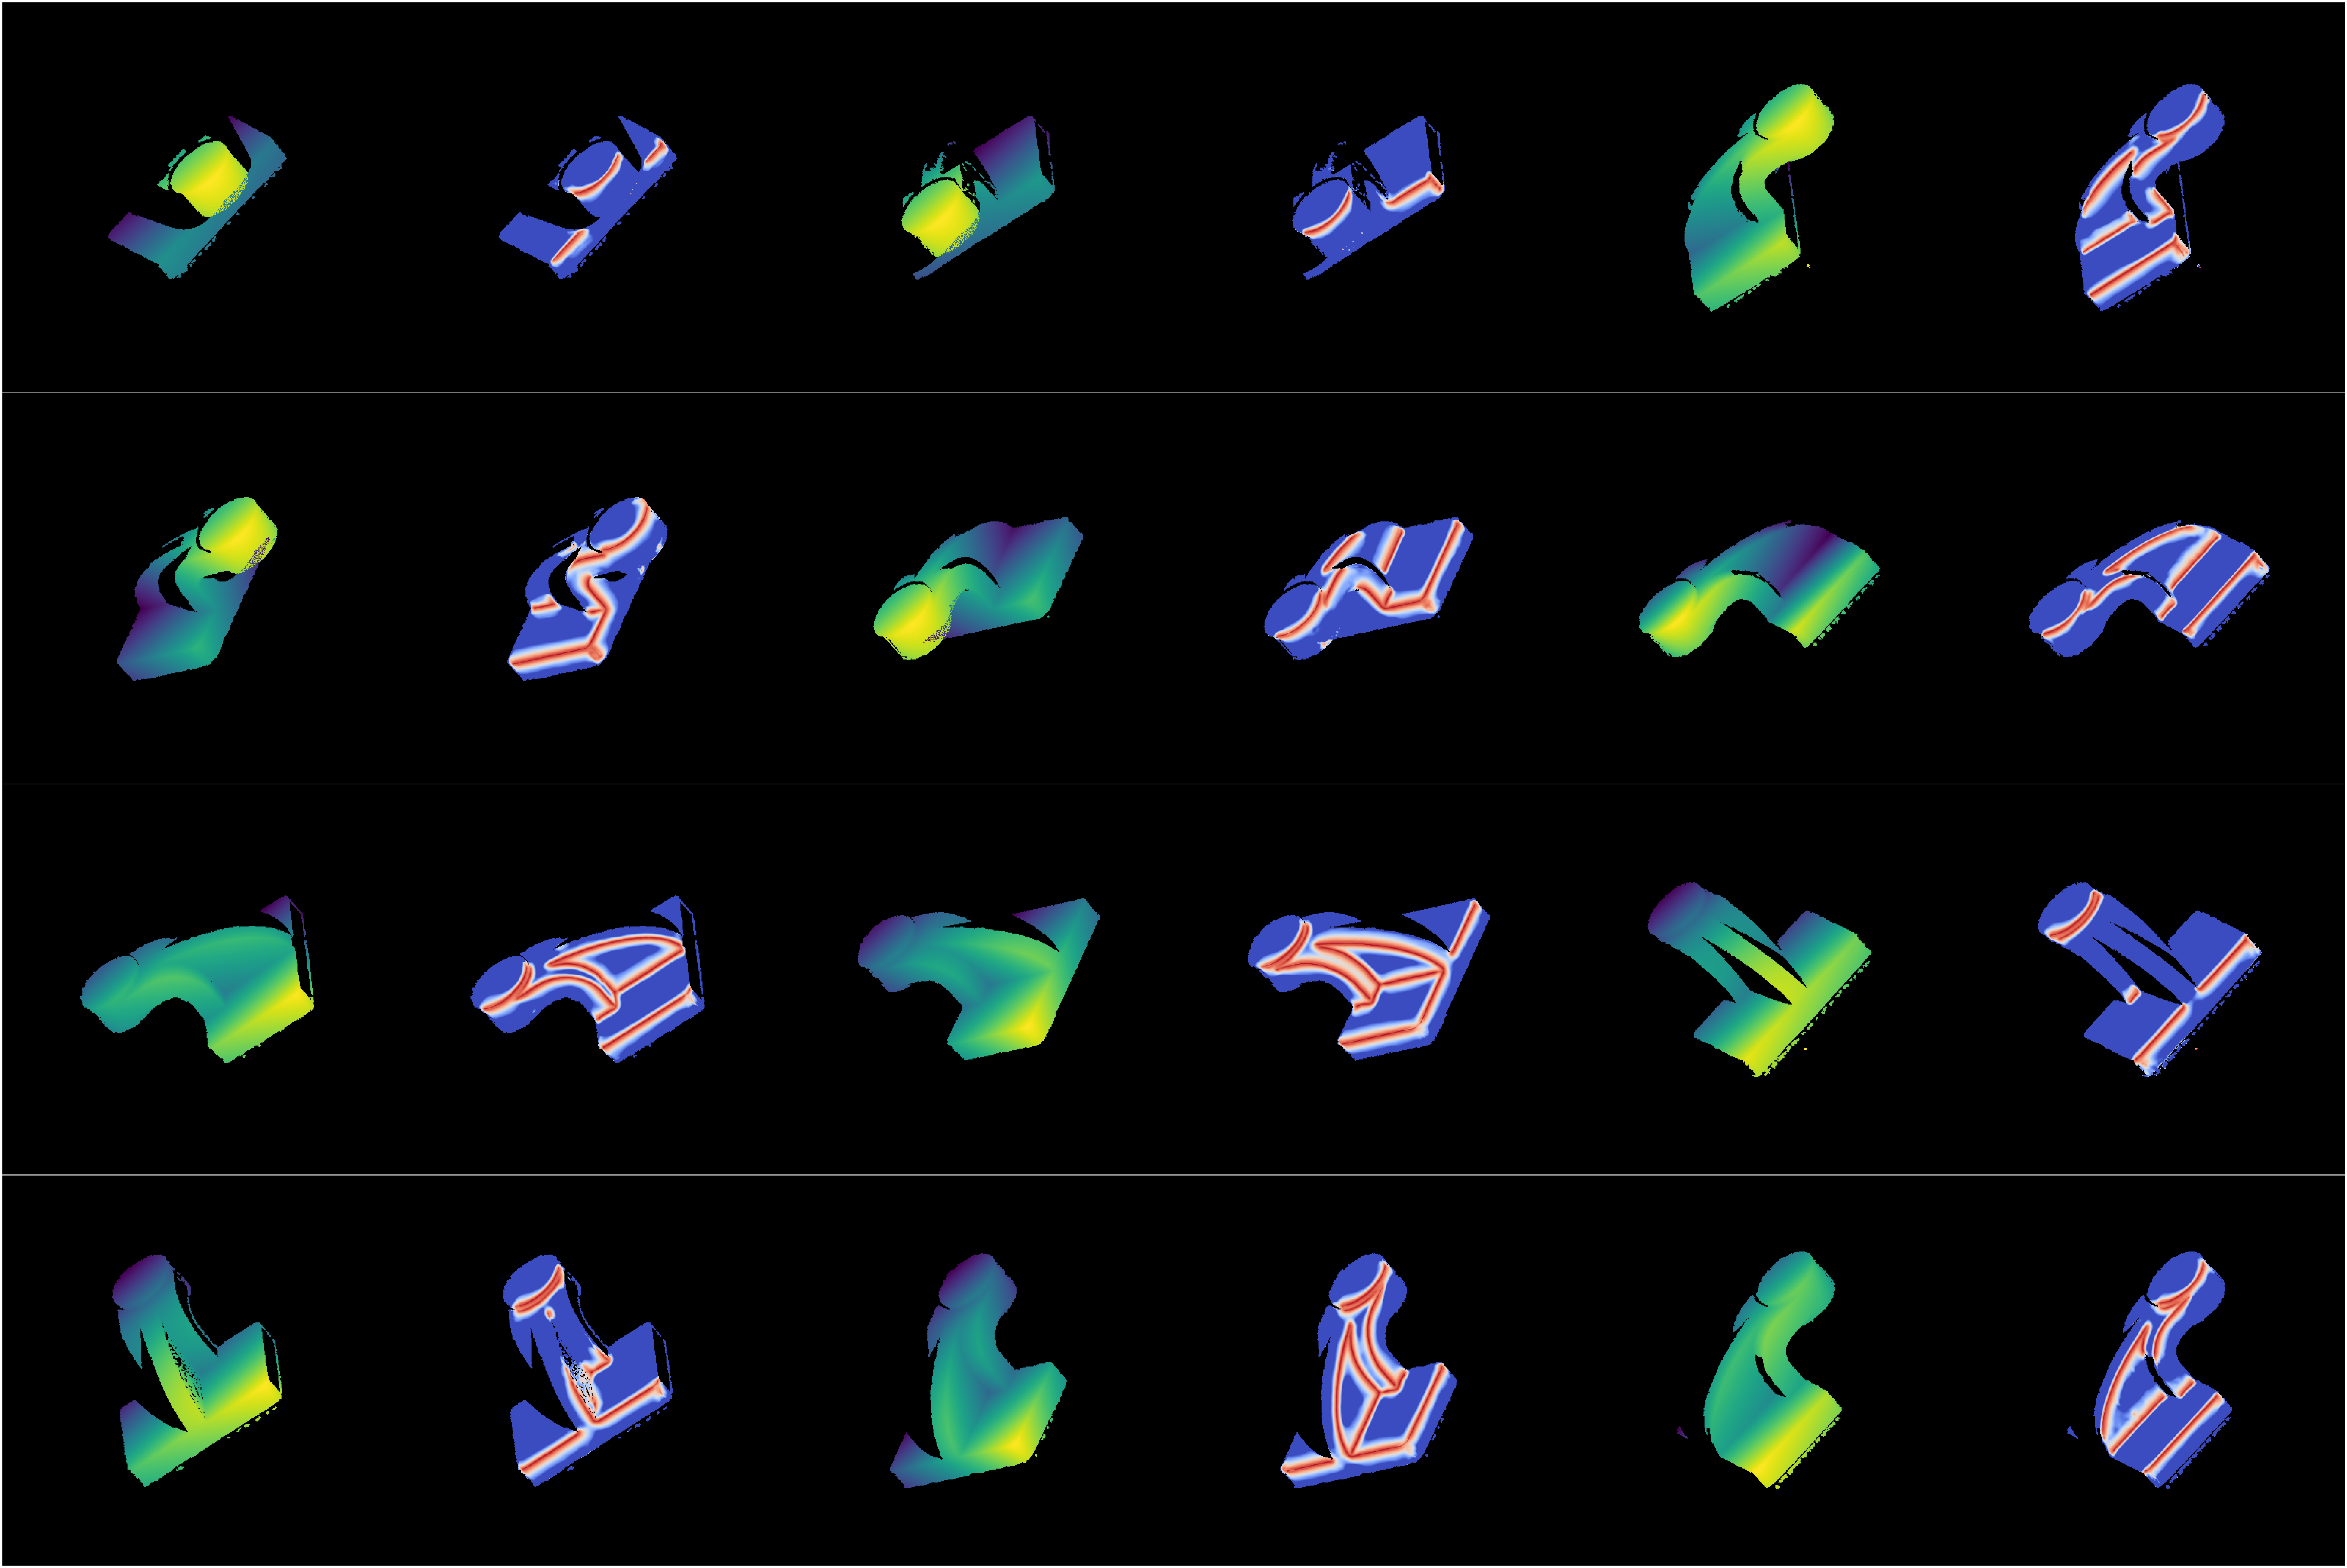

In [436]:
display_depth_sharpness(
    depth_images=[i[::-1] for i in gt_images],
    sharpness_images=[i[::-1] for i in pred_images_distances_masked],
    axes_size=(16, 16),
    ncols=3
)

In [376]:
def load_scans(base_dir):
    matlab_project_filename = glob.glob(os.path.join(base_dir, '*.mlp'))[0]
    root = ET.parse(matlab_project_filename).getroot()

    filenames = []
    points_by_scan = []
    transform_by_scan_4x4 = []

    item_id = None
    for type_tag in root.findall('MeshGroup/MLMesh'):
        filename = type_tag.get('filename')
        
        print(filename)
        if filename.endswith('.obj'):
            item_id = filename

        elif filename.endswith('.ply'):
            try:
                transform = np.loadtxt(
                    StringIO(type_tag.find('MLMatrix44').text))
                points = trimesh.load(os.path.join(base_dir, filename)).vertices
            except ValueError as e:
                continue
            
            transform_by_scan_4x4.append(transform)
            points_by_scan.append(points)
            filenames.append(filename)
            
    return filenames, points_by_scan, transform_by_scan_4x4, item_id

In [377]:
os.path.join(base_groundtruth_dir, obj_name + '_registered')

'/data/abc/sharp_features_whole_models/20201112_40cm_big_registered'

In [378]:
filenames, points_by_scan, transform_by_scan_4x4, item_id = \
    load_scans(os.path.join(base_groundtruth_dir, obj_name + '_registered'))


00500041_5aa40dcd43fa0b14df9bdcf8_trimesh_010.obj
20201112_40cm_Big 0.ply
20201112_40cm_Big 1.ply
20201112_40cm_Big 2.ply
20201112_40cm_Big 6.ply
20201112_40cm_Big 8.ply
20201112_40cm_Big 9.ply
20201112_40cm_Big 11.ply


In [394]:
def project_to_camera(
        points,
        pose: CameraPose,
        Kf: np.array,
        Ks: np.array,
        image_size: Tuple[int, int],
):
    X_world = points

    # transform to camera frame
    X_camera = pose.world_to_camera(X_world)

    # project using perspective projection
    x_image = np.dot(Kf, X_camera.T).T

    # separate XY (image coordinates) and Z
    x_image_saved = x_image.copy()
    depth = x_image[:, 2].copy()
    x_image[:, 2] = 1.

    # obtain XY in pixel coordinates
    x_pixel = np.dot(Ks, x_image.T).T
    x_pixel = np.round(x_pixel).astype(np.int32)

    # construct image
    image_offset = np.min(x_pixel, axis=0)[:2]
    image_size = np.max(x_pixel, axis=0) - np.min(x_pixel, axis=0) + 1
    print('Overwriting image_size with ', (image_size[1], image_size[0]))

    image = np.zeros((image_size[1], image_size[0]))
    image[
        x_pixel[:, 1] - image_offset[1],
        x_pixel[:, 0] - image_offset[0]] = depth

    # image = np.zeros((image_size[1] + 1, image_size[0] + 1))
    # image[x_pixel[:, 1], x_pixel[:, 0]] = depth

    return X_camera, x_pixel, x_image_saved, image, (image_offset[0], image_offset[1]),



def reproject_image_to_points(
    image,
    pose: CameraPose,
    Kf: np.array,
    Ks: np.array,
    image_offset: Tuple[int, int],
):
    image_size = (
        image.shape[1] + image_offset[0], 
        image.shape[0] + image_offset[1])

#     x_mm = np.linspace(0, 2048 / s_x, 2048)
#     y_mm = np.linspace(0, 1536 / s_y, 1536)
    i = np.arange(image_offset[0], image_offset[0] + image.shape[1])
    j = np.arange(image_offset[1], image_offset[1] + image.shape[0])
    i, j = np.meshgrid(i, j)
    
    x_pixel = np.stack((i, j, np.ones_like(i))) #.reshape((3, -1)).T
    x_pixel = x_pixel[:, image != 0].T
    
    x_image = np.dot(
        np.linalg.inv(Ks),
        x_pixel.T).T
    x_image[:, 2] = image[image != 0].ravel()

    X_camera = np.dot(
        np.linalg.inv(Kf),
        x_image.T).T
    
    X = pose.camera_to_world(X_camera)
    
    return x_pixel, x_image, X_camera, X

In [380]:
idx = 0
image = gt_images[idx]
yy, xx = np.where(image)
image_crop = image[np.min(yy):-np.min(yy), np.min(xx):-np.min(xx)]

pose = CameraPose(gt_extrinsics[idx])
Kf = gt_intrinsics_f[idx]
Ks = gt_intrinsics_s[idx]
image_offset = gt_offsets[idx]

In [381]:
x_pixel_re, x_image_re, X_camera_re, X_re = reproject_image_to_points(
    image_crop,
    pose,
    Kf, 
    Ks,
    image_offset
)

In [382]:
display_sharpness(
    samples=X_re,
    samples_distances=pred_images_distances_masked[idx][pred_images_distances_masked[idx] != 0.0].ravel(),
    samples_psize=0.4
)

Output()

In [383]:
gt_idx_by_filename = {
    filename: [idx for idx, item_id in enumerate(gt_items) if item_id.endswith(filename)][0]
    for filename in filenames
}
gt_idx_by_filename

{'20201112_40cm_Big 0.ply': 0,
 '20201112_40cm_Big 1.ply': 1,
 '20201112_40cm_Big 2.ply': 4,
 '20201112_40cm_Big 6.ply': 8,
 '20201112_40cm_Big 8.ply': 10,
 '20201112_40cm_Big 9.ply': 11,
 '20201112_40cm_Big 11.ply': 3}

In [388]:
transforms = []
for item_id in gt_items:
    found = False
    for filename, transform in zip(filenames, transform_by_scan_4x4):
        if item_id.endswith(filename):
            transforms.append(transform)
            found = True
            break
    if not found:
        transforms.append(None)

In [384]:
whole_model_points_gt = []

for filename, scanned_points, transform in zip(filenames, points_by_scan, transform_by_scan_4x4):
    idx = gt_idx_by_filename[filename]
    
    image = gt_images[idx]
    yy, xx = np.where(image)
    image_crop = image[np.min(yy):-np.min(yy), np.min(xx):-np.min(xx)]

    pose = CameraPose(gt_extrinsics[idx])
    Kf = gt_intrinsics_f[idx]
    Ks = gt_intrinsics_s[idx]
    image_offset = gt_offsets[idx]

    x_pixel_re, x_image_re, X_camera_re, X_re = reproject_image_to_points(
        image_crop,
        pose,
        Kf, 
        Ks,
        image_offset
    )

#     points = X_re
    points = tt.transform_points(X_re, transform, translate=True)
    whole_model_points_gt.append(points)

In [385]:
whole_model_points_gt = np.concatenate(whole_model_points_gt)

In [386]:
display_sharpness(
    samples=whole_model_points_gt,
#     samples_distances=pred_images_distances_masked[idx][pred_images_distances_masked[idx] != 0.0].ravel(),
    samples_psize=0.4
)

Output()

In [387]:

def multi_view_interpolate_predictions(
        imaging: RaycastingImaging,
        gt_cameras: List[np.array],
        gt_images: List[np.array],
        predictions: List[np.array],
        verbose: bool = False,
        distance_interpolation_threshold: float = HIGH_RES * 6.
):
    """Interpolates predictions between views.

    :return:
    """
    def get_view(i):
        # use exterior variables
        pose_i = CameraPose(gt_cameras[i])
        image_i = gt_images[i]
        points_i = pose_i.camera_to_world(imaging.image_to_points(image_i))
        predictions_i = np.zeros_like(image_i)
        predictions_i[image_i != 0.] = predictions[i][image_i != 0.]
        return pose_i, image_i, points_i, predictions_i

    n_omp_threads = int(os.environ.get('OMP_NUM_THREADS', 1))
    image_space_tree = cKDTree(imaging.rays_origins[:, :2], leafsize=100)

    list_predictions, list_indexes_in_whole, list_points = [], [], []
    n_points_per_image = np.cumsum([len(np.nonzero(image.ravel())[0]) for image in gt_images])

    n_images = len(gt_images)
    for i in range(n_images):
        # Propagating predictions from view i into all other views
        pose_i, image_i, points_i, predictions_i = get_view(i)

        for j in range(n_images):
            start_idx, end_idx = (0, n_points_per_image[j]) if 0 == j \
                else (n_points_per_image[j - 1], n_points_per_image[j])
            indexes_in_whole = np.arange(start_idx, end_idx)

            if verbose:
                eprint_t('Propagating views {} -> {}'.format(i, j))

            if i == j:
                list_points.append(points_i)
                list_predictions.append(predictions_i[image_i != 0.].ravel())
                list_indexes_in_whole.append(indexes_in_whole)

            else:
                pose_j, image_j, points_j, predictions_j = get_view(j)

                # reproject points from one view j to view i, to be able to interpolate in view i
                reprojected = pose_i.world_to_camera(points_j)

                # extract pixel indexes in view i (for each reprojected points),
                # these are source pixels to interpolate from
                _, nn_indexes = image_space_tree.query(
                    reprojected[:, :2],
                    k=4,
                    n_jobs=n_omp_threads)

                can_interpolate = np.zeros(len(reprojected)).astype(bool)
                interpolated_distances_j = np.zeros_like(can_interpolate).astype(float)

                for idx, reprojected_point in enumerate(reprojected):
                    # build neighbourhood of each reprojected point by taking
                    # xy values from pixel grid and z value from depth image
                    nbhood_of_reprojected = np.hstack((
                        imaging.rays_origins[:, :2][nn_indexes[idx]],
                        np.atleast_2d(image_i.ravel()[nn_indexes[idx]]).T
                    ))
                    distances_to_nearest = np.linalg.norm(reprojected_point - nbhood_of_reprojected, axis=1)
                    can_interpolate[idx] = np.all(distances_to_nearest < distance_interpolation_threshold)

                    if can_interpolate[idx]:
                        try:
                            interpolator = interpolate.interp2d(
                                nbhood_of_reprojected[:, 0],
                                nbhood_of_reprojected[:, 1],
                                predictions_i.ravel()[nn_indexes[idx]],
                                kind='linear')
                            interpolated_distances_j[idx] = interpolator(
                                reprojected_point[0],
                                reprojected_point[1])[0]
                        except ValueError as e:
                            eprint_t('Error while interpolating point {idx}: {what}, skipping this point'.format(
                                idx=idx, what=str(e)))
                            can_interpolate[idx] = False


                list_points.append(points_j[can_interpolate])
                list_predictions.append(interpolated_distances_j[can_interpolate])
                list_indexes_in_whole.append(indexes_in_whole[can_interpolate])

    return list_predictions, list_indexes_in_whole, list_points


NameError: name 'RaycastingImaging' is not defined

In [367]:
gt_idx_by_filename

{'20201113_castle_45 0.ply': 0,
 '20201113_castle_45 1.ply': 1,
 '20201113_castle_45 3.ply': 5,
 '20201113_castle_45 4.ply': 6,
 '20201113_castle_45 5.ply': 7,
 '20201113_castle_45 7.ply': 9,
 '20201113_castle_45 8.ply': 10,
 '20201113_castle_45 9.ply': 11,
 '20201113_castle_45 10.ply': 2,
 '20201113_castle_45 11.ply': 3,
 '20201113_castle_45 2.ply': 4,
 '20201113_castle_45 6.ply': 8}

In [405]:
def data_crop(image):
    yy, xx = np.where(image)
    return image[np.min(yy):-np.min(yy), np.min(xx):-np.min(xx)]

In [391]:
def get_view(i):
    # use exterior variables
    pose_i = CameraPose(gt_extrinsics[i])
    Kf_i, Ks_i = gt_intrinsics_f[i], gt_intrinsics_s[i]
    offset_i = gt_offsets[i]
    image_i = gt_images[i]

    yy, xx = np.where(image_i)
    image_crop = image_i[np.min(yy):-np.min(yy), np.min(xx):-np.min(xx)]
    _, _, _, points_i = reproject_image_to_points(
        image_crop, pose_i, Kf_i, Ks_i, offset_i)
    
    transform_i = transforms[i]
    points_i = tt.transform_points(points_i, transform_i, translate=True)

    predictions_i = np.zeros_like(image_i)
    predictions_i[image_i != 0.] = pred_images_distances_masked[i][image_i != 0.]
    return (transform_i, pose_i, Kf_i, Ks_i, offset_i), image_i, points_i, predictions_i



In [392]:
(transform_i, pose_i, Kf_i, Ks_i, offset_i), image_i, points_i, predictions_i = get_view(0)

In [393]:
(transform_j, pose_j, Kf_j, Ks_j, offset_j), image_j, points_j, predictions_j = get_view(1)

In [399]:
# reproject points from one view j to view i, to be able to interpolate in view i
_, _, _, reprojected, reprojected_offset = project_to_camera(
    tt.transform_points(points_j, np.linalg.inv(transform_j)),
    pose_i,
    Kf_i,
    Ks_i,
    image_size=(512, 512),
)


Overwriting image_size with  (318, 365)


In [ ]:
i = np.arange(image_offset[0], image_offset[0] + image.shape[1])
j = np.arange(image_offset[1], image_offset[1] + image.shape[0])
i, j = np.meshgrid(i, j)



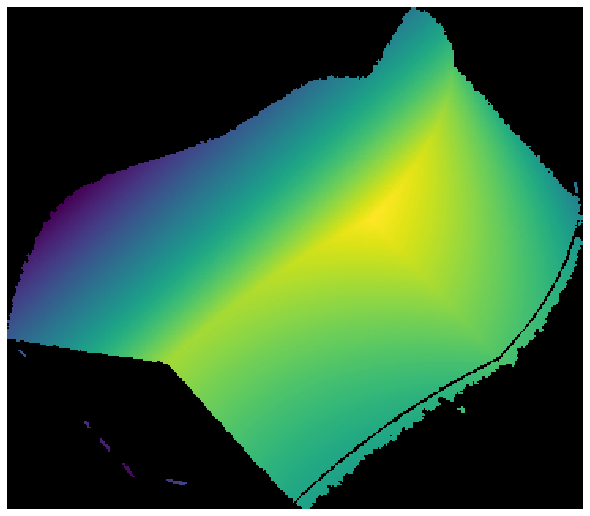

In [408]:
display_depth_sharpness([reprojected[::-1]])

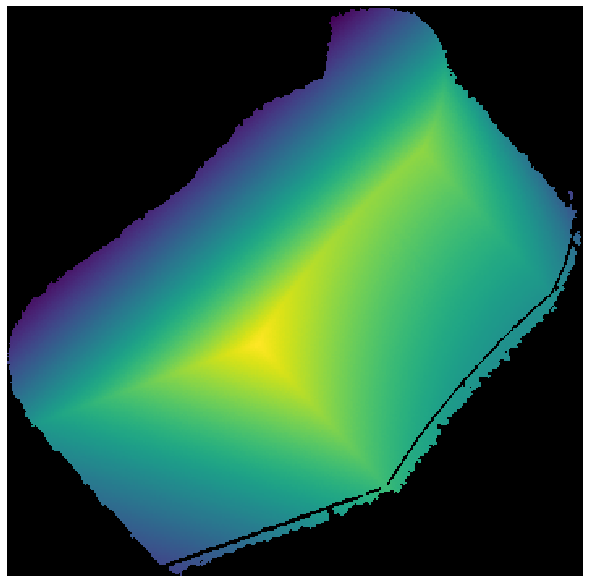

In [409]:
display_depth_sharpness([data_crop(image_i)[::-1]])

In [410]:

# extract pixel indexes in view i (for each reprojected points),
# these are source pixels to interpolate from
_, nn_indexes = image_space_tree.query(
    reprojected[:, :2],
    k=4,
    n_jobs=n_omp_threads)

NameError: name 'image_space_tree' is not defined

In [ ]:


can_interpolate = np.zeros(len(reprojected)).astype(bool)
interpolated_distances_j = np.zeros_like(can_interpolate).astype(float)

for idx, reprojected_point in enumerate(reprojected):
    # build neighbourhood of each reprojected point by taking
    # xy values from pixel grid and z value from depth image
    nbhood_of_reprojected = np.hstack((
        imaging.rays_origins[:, :2][nn_indexes[idx]],
        np.atleast_2d(image_i.ravel()[nn_indexes[idx]]).T
    ))
    distances_to_nearest = np.linalg.norm(reprojected_point - nbhood_of_reprojected, axis=1)
    can_interpolate[idx] = np.all(distances_to_nearest < distance_interpolation_threshold)

    if can_interpolate[idx]:
        try:
            interpolator = interpolate.interp2d(
                nbhood_of_reprojected[:, 0],
                nbhood_of_reprojected[:, 1],
                predictions_i.ravel()[nn_indexes[idx]],
                kind='linear')
            interpolated_distances_j[idx] = interpolator(
                reprojected_point[0],
                reprojected_point[1])[0]
        except ValueError as e:
            eprint_t('Error while interpolating point {idx}: {what}, skipping this point'.format(
                idx=idx, what=str(e)))
            can_interpolate[idx] = False


